## This assignment is designed for automated pathology detection for Medical Images in a relalistic setup, i.e. each image may have multiple pathologies/disorders. 
### The goal, for you as an MLE, is to design models and methods to predictively detect pathological images and explain the pathology sites in the image data.

## Data for this assignment is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview
Explanation of the data set:
The training data set contains 3435 retinal images that represent multiple pathological disorders. The patholgy classes and corresponding labels are: included in 'train.csv' file and each image can have more than one class category (multiple pathologies).
The labels for each image are

```
-opacity (0), 
-diabetic retinopathy (1), 
-glaucoma (2),
-macular edema (3),
-macular degeneration (4),
-retinal vascular occlusion (5)
-normal (6)
```
The test data set contains 350 unlabelled images.

# For this assignment, you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model along with feature explanability and self-learning for Diabetic Retinopathy and Glaucoma vs. Normal images.
# Design models and methods for the following tasks. Each task should be accompanied by code, plots/images (if applicable), tables (if applicable) and text:
## Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images. You may consider multi-class classification vs. all-vs-one classification. Clearly state your choice and share details of your model, paremeters and hyper-paramaterization pprocess. (60 points)
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. You can choose to apply any data augmentation strategy. 
Explain your methods and rationale behind parameter selection.
c. Show Training-validation curves to ensure overfitting and underfitting is avoided.
```
## Task 2: Visualize the heatmap/saliency/features using any method of your choice to demonstrate what regions of interest contribute to Diabetic Retinopathy and Glaucoma, respectively. (25 points)
```
Submit images/folder of images with heatmaps/features aligned on top of the images, or corresponding bounding boxes, and report what regions of interest in your opinion represent the pathological sites.
```

## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.(15 points)
[You may use any method of your choice, one possible way is mentioned below.] 

```
Hint: 
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. (20 points)
```

## [Hint: If you are wondering how to use the "dense layer representative of an image" in step 2, see this exercise that extracts a [1,2048] dense representattive from an image using the InceptionV3 pre-trained model.]
https://colab.research.google.com/drive/14-6qRGARgBSj4isZk86zKQtyIT2f9Wu1#scrollTo=_IqraxtP4Ex3


## Good Luck!

#Task 1: Build a classification model for Diabetic Retinopathy and Glaucoma vs normal images.

In [1]:
#Load libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
#resnet50 = resnet.ResNet50
#from keras.applications.resnet import preprocess_input



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/FourthBrainMLE/week_8

/content/drive/MyDrive/FourthBrainMLE/week_8


In [ ]:
#!unzip Data.zip

In [4]:
train_csv_data = pd.read_csv("./Data/train/train.csv")
train_csv_data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [5]:
train_csv_data.shape

(3435, 8)

#Analyzing the distribution of 0 and 1 labels for each class category

In [6]:
for label in train_csv_data.columns[1:]:
  print('Distribution of 0 and 1 in the class:', label)
  print(train_csv_data[label].value_counts())
  print('')

Distribution of 0 and 1 in the class: opacity
0    1902
1    1533
Name: opacity, dtype: int64

Distribution of 0 and 1 in the class: diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64

Distribution of 0 and 1 in the class: glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64

Distribution of 0 and 1 in the class: macular edema
0    2919
1     516
Name: macular edema, dtype: int64

Distribution of 0 and 1 in the class: macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64

Distribution of 0 and 1 in the class: retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64

Distribution of 0 and 1 in the class: normal
0    2910
1     525
Name: normal, dtype: int64



####It can be observe that for each class the total number of 'label 0' is much higher than the 'label 1'.

####Total number of images with single or multiple class categories (i.e. multiple pathologies).

In [7]:
labels = train_csv_data.columns[1:]
def multiple_labels(row):
  return ",".join([labels[i] for i, value in enumerate(row[1:]) if value == 1])

train_csv_data.apply(lambda x: multiple_labels(x), axis=1).value_counts()


opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
opacity,macular degeneration                                             212
diabetic retinopathy                                                     212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

#### It can be seen that higher number of images labeled with opacity, normal, glaucoma, macular degeneration, and diabetic retinopathy class categories. The rest of the images are labeled with multiple class actegories. The class distribution clearly indicates that image data set is highly imbalanced. 

## Extracting diabetic retinopathy, glaucoma, normal class categories

In [8]:
#Images label extraction for normal, diabetic retinopathy, glaucoma class categories
normal_label = np.array(train_csv_data.index[(train_csv_data['normal'] == 1)])
diabetic_retinopathy_label = np.array(train_csv_data.index[(train_csv_data['diabetic retinopathy'] == 1)])
glaucoma_label = np.array(train_csv_data.index[(train_csv_data['glaucoma'] == 1)])
array_label = np.concatenate((np.concatenate((diabetic_retinopathy_label, glaucoma_label)), normal_label))
image_labels = np.array(train_csv_data.loc[array_label,['filename']])
data_labels = np.array(train_csv_data.loc[array_label, ['diabetic retinopathy', 'glaucoma', 'normal']])
#data_labels = train_csv_data.loc[array_label, ['diabetic retinopathy', 'glaucoma', 'normal']].to_numpy()

In [9]:
image_labels

array([['10ee8c8a72b4.jpg'],
       ['3b6da0297f92.jpg'],
       ['677c30357c4e.jpg'],
       ...,
       ['2477323c9434.jpg'],
       ['0a1ca36be2c5.jpg'],
       ['96f11f20fe93.jpg']], dtype=object)

In [10]:
data_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [11]:
image_labels.shape

(1877, 1)

In [12]:
data_labels.shape

(1877, 3)

In [13]:
train_path = './Data/train/train/'

In [14]:
from tqdm import tqdm
from keras.preprocessing import image

train_images = []
for i in tqdm(range(image_labels.shape[0])):
    img = image.load_img(train_path+image_labels[i][0], target_size=(256,256,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

X = np.array(train_images)

100%|██████████| 1877/1877 [20:56<00:00,  1.49it/s]


In [15]:
X.shape

(1877, 256, 256, 3)

In [16]:
y = data_labels
y.shape

(1877, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.15)

print(f'X_train_shape {X_train.shape}, X_test_shape {X_test.shape}, y_train_shape {y_train.shape}, y_test_shape {y_test.shape}')

X_train_shape (1595, 256, 256, 3), X_test_shape (282, 256, 256, 3), y_train_shape (1595, 3), y_test_shape (282, 3)


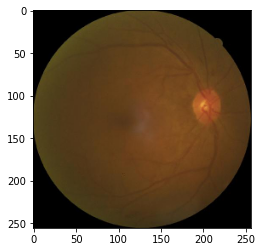

Image Class: [1 0 0]
Maximum pixel value in an image = 0.9333333373069763


In [18]:
#display sample training image
index = 110
plt.imshow(X_train[index])
plt.show()
print(f"Image Class: {y_train[index]}")
print(f"Maximum pixel value in an image = {np.max(X_train[index])}")

## InceptionV3 model

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization


# create the base pre-trained model
base_model = InceptionV3(include_top=False, weights='imagenet')

#Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

#Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# add a logistic layer of 4 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
print('Total no.of Layers:', len(model.layers))

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# to update the weight that are added
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit(X_train, y_train)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)


# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
  layer.trainable = False
for layer in model.layers[249:]:
  layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


87924736/87910968 [==============================] - 2s 0us/step
Total no.of Layers: 316
50/50 [==============================] - 16s 66ms/step - loss: 0.9988
0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 

## Gridsearch for hyperparameters tuning

We are going to gridsearch various hyperparameters like batch size, learning rate, and momentum to see what will give us the most effective model for our full training set.

In [ ]:
'''
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model():
  grid_model = model
  return grid_model

model1 = KerasClassifier(build_fn = create_model, verbose = 0)

# define the grid search parameters
#batch_size = [32, 64]
#epochs = [10, 20]

batch_size = [32]
epochs = [20, 30]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean , stdev , param in zip (means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Best: 0.916034 using {'batch_size': 32, 'epochs': 30}
0.892551 (0.104810) with: {'batch_size': 32, 'epochs': 20}
0.916034 (0.042272) with: {'batch_size': 32, 'epochs': 30}


In [22]:
# Directory for tensorboard logs
from datetime import datetime
#%load_ext tensorboard
%reload_ext tensorboard
logdir = "logs/fit1_3classes/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

callbacks = [tensorboard_callback, early_stopping_callback]

In [23]:
# Train the model alongside the top Dense layers

Inception_model_history = model.fit(X_train, y_train, batch_size=32, validation_split = 0.2, epochs=30, shuffle=True, verbose=1, callbacks=callbacks)
print("Average train loss: ", np.average(Inception_model_history.history['loss']))

Epoch 1/30
40/40 [==============================] - 11s 142ms/step - loss: 0.8757 - accuracy: 0.7116 - val_loss: 1.0724 - val_accuracy: 0.7022
Epoch 2/30
40/40 [==============================] - 3s 87ms/step - loss: 0.3795 - accuracy: 0.8597 - val_loss: 0.7980 - val_accuracy: 0.7273
Epoch 3/30
40/40 [==============================] - 3s 87ms/step - loss: 0.2729 - accuracy: 0.9036 - val_loss: 0.6515 - val_accuracy: 0.7774
Epoch 4/30
40/40 [==============================] - 3s 87ms/step - loss: 0.2031 - accuracy: 0.9357 - val_loss: 0.5485 - val_accuracy: 0.8056
Epoch 5/30
40/40 [==============================] - 3s 88ms/step - loss: 0.1525 - accuracy: 0.9561 - val_loss: 0.4878 - val_accuracy: 0.8307
Epoch 6/30
40/40 [==============================] - 4s 89ms/step - loss: 0.1530 - accuracy: 0.9592 - val_loss: 0.5074 - val_accuracy: 0.8276
Average train loss:  0.3394695073366165


In [24]:
#Plotting the model Accurcay and Loss
def Plot_History(fit_history):
  acc = [0.] + fit_history.history['accuracy']
  val_acc = [0.] + fit_history.history['val_accuracy']

  loss = fit_history.history['loss']
  val_loss = fit_history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('Eepoch')
  plt.show()

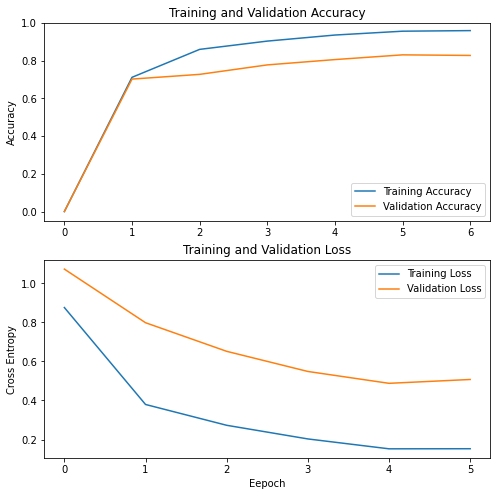

                      precision    recall  f1-score   support

diabetic retinopathy       0.77      0.90      0.83       113
            glaucoma       0.78      0.62      0.69        80
              normal       0.91      0.88      0.89        89

            accuracy                           0.82       282
           macro avg       0.82      0.80      0.81       282
        weighted avg       0.82      0.82      0.81       282

Confusion matrix : 
 [[102   9   2]
 [ 24  50   6]
 [  6   5  78]]


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Plot_History(Inception_model_history)
pred = model.predict(X_test, batch_size=32)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=['diabetic retinopathy', 'glaucoma', 'normal']))

Confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print("Confusion matrix : \n", Confusion_matrix)

In [27]:
# Receiver Operating Characteristic (ROC)

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

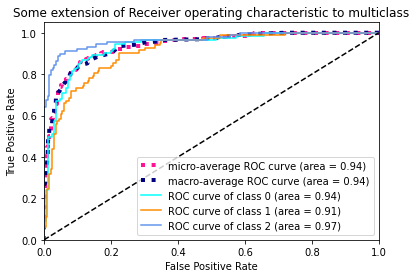

In [28]:
# Plot ROC curves for the multiclass problem
# Compute macro-average ROC curve and ROC area

from itertools import cycle
lw = 1.5
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

#Task 2: Visualize the heatmap/saliency/features
References:
1. https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
2. https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48
3. https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
4. https://www.kaggle.com/asraf047/grad-cam-cnn
5. https://keras.io/examples/vision/grad_cam/

In [29]:
import matplotlib.cm as cm
from tensorflow import GradientTape
#from keras.wrappers.scikit_learn import KerasClassifier

In [30]:
# Relevant layer names
last_conv_layer_name = 'conv2d_93'

In [31]:
# Heatmap functions
def make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=None):
  img_array = np.expand_dims(img, axis=0)
  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]
  
  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

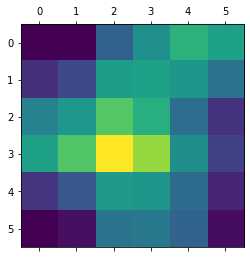

In [32]:
# Use a test example to make sure our function works
heatmap = make_gradcam_heatmap(X_train[5], model, last_conv_layer_name, pred_index=None)

plt.matshow(heatmap)

### Demonstration
Now, we'll put it all together and show our heatmaps superimposed on top of some images, along with the class of that image, so we can see what the model is looking at for each class of image.

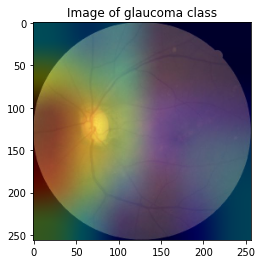

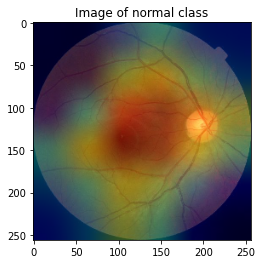

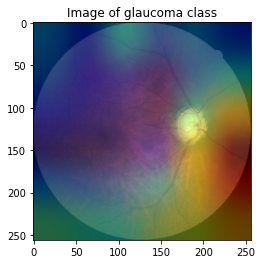

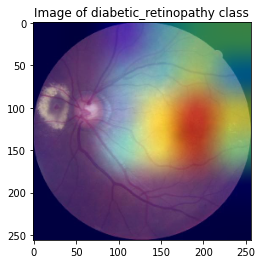

In [33]:
class_dict = {0: "diabetic_retinopathy", 1: "glaucoma", 2: "normal"}

for i in range(1, 5):
  img_class = class_dict.get(np.argmax(y_train[i], axis=-1))
  img = X_train[i]
  heatmap = make_gradcam_heatmap(img, model, 
                                 last_conv_layer_name, 
                                 pred_index=None)
  heatmap = np.uint8(255 * heatmap)
  img = img * 255.
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.5 + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
  # Display Grad CAM
  plt.subplots(1,1)
  plt.title(f"Image of {img_class} class")
  plt.imshow(superimposed_img)

In [34]:
# A function to display a heatmap
def show_heatmap(idx):
  class_dict = {0: "diabetic_retinopathy", 1: "glaucoma", 2: "normal"}
  img_class = class_dict.get(np.argmax(y_train[idx], axis=-1))
  img = X_train[idx]  
  heatmap = make_gradcam_heatmap(img, model, 
                                 last_conv_layer_name, 
                                 pred_index=None)
  heatmap = np.uint8(255 * heatmap)
  img = img * 255.
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.5 + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  # Display Grad CAM
  plt.subplots(1,1)
  plt.title(f"Image of {img_class} class")
  plt.imshow(superimposed_img)

## Examples of each class, with heatmaps
Now, we'll show off some examples of each class in the dataset and print heatmaps for each one.

In [35]:
# Labels for first 20 items in training
class_labels = np.argmax(y_train[:20], axis=1).reshape(-1,1)

### Heatmaps for some diabetic retinopathy images.

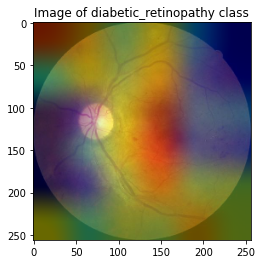

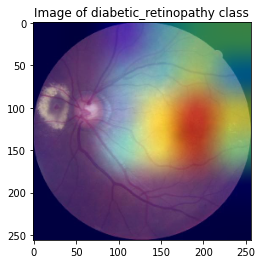

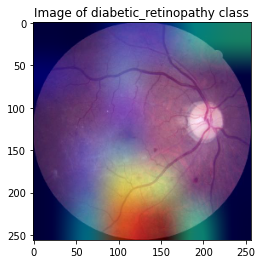

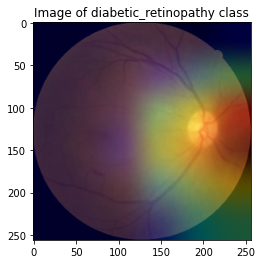

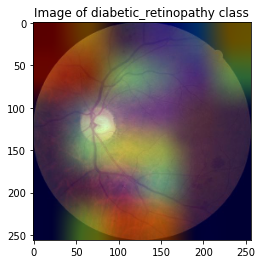

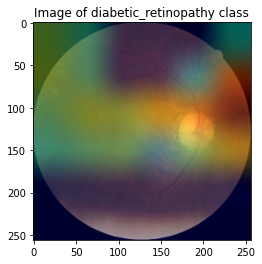

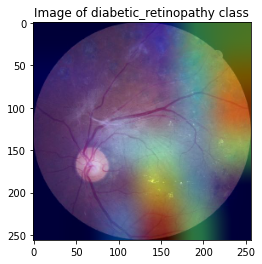

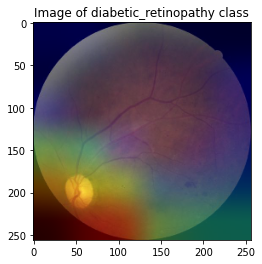

In [36]:
# diabetic_retinopathy images heatmaps
for i in np.where(class_labels == 0)[0]:
  show_heatmap(i)

Discussion: The heatmaps indicate that the model looks for the growth of scar tissue resulted from the abnormal blood vessels associated with diabetic retinopathy.

### Heatmaps for some glaucoma images

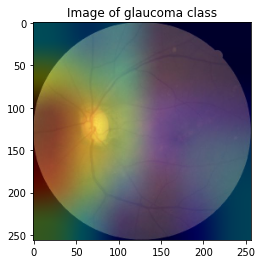

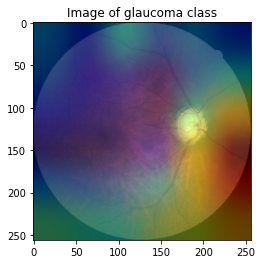

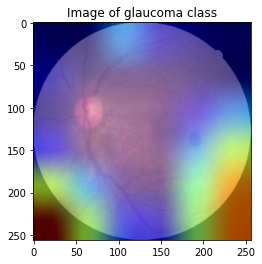

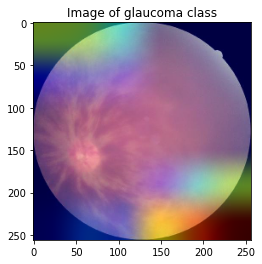

In [37]:
# glaucoma images heatmaps
for i in np.where(class_labels == 1)[0]:
  show_heatmap(i)

Discussion: The model seems to looking for glaucoma pathology on the optic nerve.

### Heatmaps for some normal images

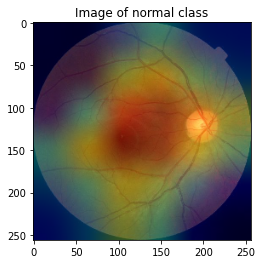

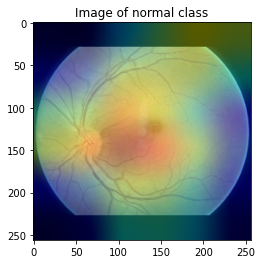

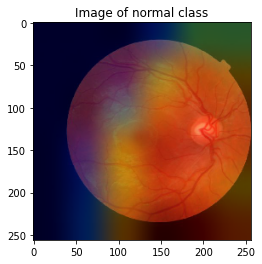

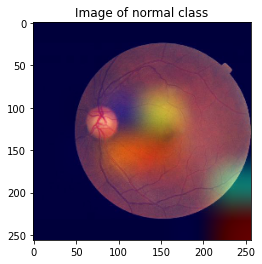

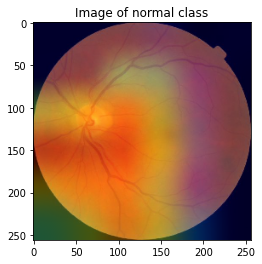

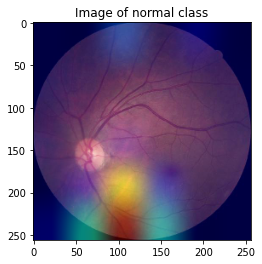

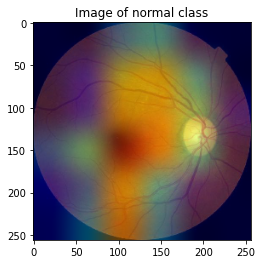

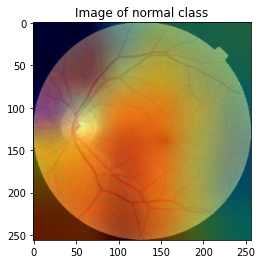

In [38]:
# normal images heatmaps
for i in np.where(class_labels == 2)[0]:
  show_heatmap(i)

Discussion: For the normal images, the model is looking at the border of the image due to the lack of features of diabetic retinopathy and glaucoma symptoms or any other symptoms.

#Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.

In [39]:
import glob
test_path = "./Data/test/test"
unlabeled_test_images = glob.glob(test_path + '/*.jpg')
print(len(unlabeled_test_images))


350


In [40]:
test_images = []
for i in tqdm(range(len(unlabeled_test_images))):
  img = image.load_img(unlabeled_test_images[i], target_size=(256, 256, 1), grayscale=False)
  img = image.img_to_array(img)
  img = img/255
  test_images.append(img)

test_images = np.array(test_images)

100%|██████████| 350/350 [00:06<00:00, 57.45it/s] 


In [41]:
test_images.shape

(350, 256, 256, 3)

file_name = ./Data/test/test/07e4191fa3a8.jpg


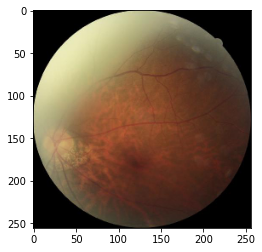

In [42]:
print('file_name =', unlabeled_test_images[10])
plt.imshow(test_images[10])
plt.show()

## Create model with last dense layer output

In [43]:
# Create model with the model's output dense layer
dense_layer = 'dense_1'
dense_model = tf.keras.models.Model(inputs=model.input,
                    outputs=model.get_layer(dense_layer).output)
# Pass labeled and unlabeled data
labeled_dense_output = dense_model.predict(X_train)
unlabeled_dense_output = dense_model.predict(test_images)

In [44]:
# concatenate dense outputs 
X_full_dense_output = np.concatenate((labeled_dense_output, unlabeled_dense_output), axis=0)
X_full_dense_output.shape

(1945, 3)

## Label Spreading

1. We can use SciKitLearn LabelSpreading() function to provide labels to our unlabeled test_images datset. So, first we must convert our one-hot encoded labels of y_train back to categorical integers.

2. The SciKitLearn LabelSpreading() function also requires us to add filler labels of -1 to all unalabed data to differentiate it properly.

3. The LabelSpreading() function will use the distributions of our concatened labeled and unlabeled data (retrieved from the dense output layer of the model) to add labels to unlabeled test_images.

4. Then we will convert them back to one-hot encoding, and concatenate with Xs to match our aded labels, and retrain the model on the augmented dataset.

In [45]:
# Difference between the concatenated(full data = labeled + Unlabeled) and labeled
diff = X_full_dense_output.shape[0] - y_train.shape[0]
print(diff)

350


In [46]:
# Convert labels from one-hot to int
y_train_class_labels = np.argmax(y_train, axis=1).reshape(-1,1)
print(y_train_class_labels[:10])
print(y_train_class_labels.shape)

[[0]
 [1]
 [2]
 [1]
 [0]
 [2]
 [2]
 [2]
 [2]
 [0]]
(1595, 1)


In [47]:
# pad y_train with -1s to make it the same size as concatenated full image data
dummies = np.full((350, 1), -1)
print(dummies[:10])
print(dummies.shape)
y_full = np.concatenate((y_train_class_labels, dummies), axis=0)
print("y_full shape", y_full.shape)
print("X_full_dense_output shape", X_full_dense_output.shape)

[[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]
(350, 1)
y_full shape (1945, 1)
X_full_dense_output shape (1945, 3)


In [48]:
y_full

array([[ 0],
       [ 1],
       [ 2],
       ...,
       [-1],
       [-1],
       [-1]])

In [49]:
from sklearn.semi_supervised import LabelSpreading

# Fit label spreading model
lp_model = LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(X_full_dense_output, y_full)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelSpreading(gamma=0.25, max_iter=20)

In [50]:
predicted_labels = lp_model.transduction_

In [51]:
predicted_labels.shape

(1945,)

In [52]:
predicted_labels

array([0, 1, 2, ..., 0, 0, 0])

In [53]:
predicted_labels[1595:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,

In [54]:
# Convert back y_full to one-hot
y_full = np.array(pd.get_dummies(predicted_labels))
y_full.shape

(1945, 3)

In [55]:
# Combine X_train and unlabeled test_images
print(X_train.shape, test_images.shape)
X_full = np.concatenate((X_train, test_images), axis=0)
X_full.shape

(1595, 256, 256, 3) (350, 256, 256, 3)


(1945, 256, 256, 3)

In [56]:
# Directory for tensorboard logs
from datetime import datetime
#%load_ext tensorboard
%reload_ext tensorboard
logdir = "logs/fit2_3classes/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

callbacks = [tensorboard_callback, early_stopping_callback]

In [57]:
# Complie the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
# Training the model with augmented data

Inception_model_history_full = model.fit(X_full, y_full, batch_size=32, validation_split = 0.2, epochs=30, shuffle=True, verbose=1, callbacks=callbacks)
print("Average train loss: ", np.average(Inception_model_history_full.history['loss']))

Epoch 1/30
49/49 [==============================] - 10s 127ms/step - loss: 0.1962 - accuracy: 0.9344 - val_loss: 0.5121 - val_accuracy: 0.8098
Epoch 2/30
49/49 [==============================] - 4s 86ms/step - loss: 0.0899 - accuracy: 0.9698 - val_loss: 0.5310 - val_accuracy: 0.8072
Epoch 3/30
49/49 [==============================] - 4s 86ms/step - loss: 0.0552 - accuracy: 0.9839 - val_loss: 0.5873 - val_accuracy: 0.7969
Epoch 4/30
49/49 [==============================] - 4s 86ms/step - loss: 0.0485 - accuracy: 0.9891 - val_loss: 0.6173 - val_accuracy: 0.7841
Epoch 5/30
49/49 [==============================] - 4s 86ms/step - loss: 0.0436 - accuracy: 0.9916 - val_loss: 0.6312 - val_accuracy: 0.7918
Epoch 6/30
49/49 [==============================] - 4s 87ms/step - loss: 0.0396 - accuracy: 0.9884 - val_loss: 0.6117 - val_accuracy: 0.7918
Epoch 7/30
49/49 [==============================] - 4s 86ms/step - loss: 0.0402 - accuracy: 0.9871 - val_loss: 0.6332 - val_accuracy: 0.7995
Average tra

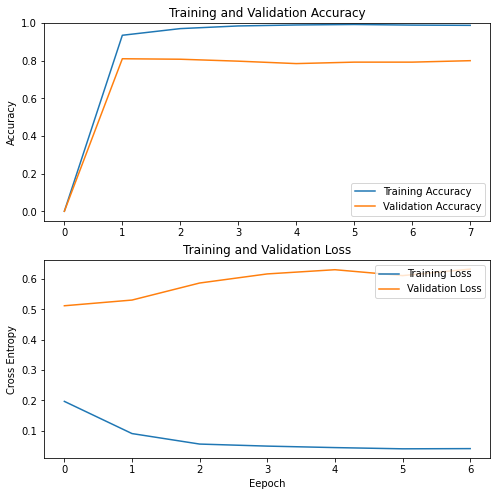

                      precision    recall  f1-score   support

diabetic retinopathy       0.84      0.85      0.85       113
            glaucoma       0.78      0.78      0.78        80
              normal       0.92      0.91      0.92        89

            accuracy                           0.85       282
           macro avg       0.85      0.84      0.85       282
        weighted avg       0.85      0.85      0.85       282

Confusion matrix : 
 [[96 14  3]
 [14 62  4]
 [ 4  4 81]]


In [60]:
Plot_History(Inception_model_history_full)
pred = model.predict(X_test, batch_size=32)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=['diabetic retinopathy', 'glaucoma', 'normal']))

Confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
print("Confusion matrix : \n", Confusion_matrix)

In [61]:
# Receiver Operating Characteristic (ROC)

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

n_classes = 3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

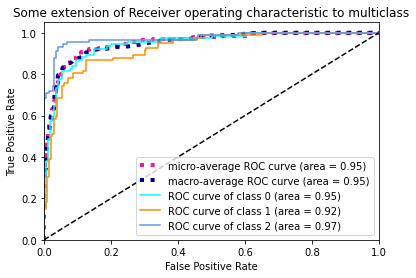

In [62]:
# Plot ROC curves for the multiclass problem
# Compute macro-average ROC curve and ROC area

from itertools import cycle
lw = 1.5
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### Discussion: The model over all accuracy (f1-score) and AUC on the unseen test data is increased slightly when trained on the augmented data (total images data).